<a href="https://colab.research.google.com/github/jbloewencolon/Psychedelic-Trip-Generator/blob/main/BigBird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
#!pip install sentencepiece
#!pip install transformers
#!pip install lime

import pandas as pd
import numpy as np
import os
import sentencepiece
from joblib import dump, load
import torch
from torch import device
from tqdm import tqdm
from transformers import BigBirdTokenizer, BigBirdModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283838 sha256=9e420e27d9ded8fbbf4368e60432539217826c0d07e481aaa3f3e83f452126d9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [32]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/processed.csv')

In [38]:
df.drop(columns='Unnamed: 0', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67516 entries, 0 to 67515
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             67516 non-null  object 
 1   drug              67516 non-null  object 
 2   dosage            67516 non-null  object 
 3   delivery          67516 non-null  object 
 4   weight            67516 non-null  float64
 5   year              67516 non-null  int64  
 6   gender            67516 non-null  object 
 7   report            67516 non-null  object 
 8   processed_report  67516 non-null  object 
 9   mixed             67516 non-null  int64  
 10  drug_category     67516 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 5.7+ MB


In [ ]:
df.value_counts('drug_category')

drug_category
Psychedelic              28214
Pharmaceutical            6540
Entactogen/Empathogen     6440
Other                     6161
Cannabinoid               5730
Stimulant                 3590
Entheogen                 3497
Dissociative              2641
Opioid                    2441
Depressant                2262
dtype: int64

In [35]:
df.head()

,Unnamed: 0,title,drug,dosage,delivery,weight,year,gender,report,processed_report,mixed,drug_category
0,0,The Happiest I Remember Feeling,mdma,1 tablet,oral,140.0,2013,female,"I had taken Ecstasy once before, but it was to...","[['i', 'had', 'taken', 'ecstasy', 'once', 'bef...",0,Entactogen/Empathogen
1,1,A Short Trip to Extravagance,cannabis,1 cig.,smoked,175.0,2005,male,It all started at about 6:00AM one morning aft...,"[['it', 'all', 'started', 'at', 'about', '600a...",1,Cannabinoid
2,2,The Yins and Yangs of the Speedball,heroin,0.1 g,IV,170.0,2007,male,INTRODUCTION:I am not just writing a ``I got f...,"[['introduction', '', 'i', 'am', 'not', 'just'...",1,Opioid
3,3,Well What Do You Know About That?,cannabis,1 bowl,smoked,145.0,2011,male,8:00 eat 160 mg of butylone on a mostly empty ...,"[['800', 'eat', '160', 'mg', 'of', 'butylone',...",1,Cannabinoid
4,4,Quick and Satisfying,tea,,oral,130.0,2012,female,Due to the recent lack of availability of mimo...,"[['due', 'to', 'the', 'recent', 'lack', 'of', ...",1,Other


In [39]:
# Define function to load pre-trained model and tokenizer
def load_pretrained_model_and_tokenizer(model_file, tokenizer_file):
    # Check if the model and tokenizer are already saved
    if os.path.exists(model_file) and os.path.exists(tokenizer_file):
        model = load(model_file)
        tokenizer = load(tokenizer_file)
    else:
        # Load pre-trained model tokenizer
        tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

        # Load pre-trained model (weights)
        model = BigBirdModel.from_pretrained('google/bigbird-roberta-base', output_hidden_states=True)
        model = model.to(device)  # Move model to GPU if available
        model.eval()  # Put the model in "evaluation" mode

        # Save the model and tokenizer files
        dump(model, model_file)
        dump(tokenizer, tokenizer_file)

    return model, tokenizer

In [40]:
def get_bigbird_embeddings(text, tokenizer, model):
    # Prepend [CLS] and append [SEP] to text
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)

    # Check tokenized text length
    if len(tokenized_text) > 4096:
        tokenized_text = tokenized_text[:4096]  # Truncate if too long

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    # Convert inputs to PyTorch tensors and move to the device
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    # Predict hidden states features for each layer
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs.hidden_states

    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    # Sum the vectors from the last four layers
    sum_vec = torch.sum(token_embeddings[-4:], dim=0)
    return sum_vec

In [41]:
# Set the device to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the directory where you want to save the file
output_dir = '/content/drive/MyDrive/Colab Notebooks/Data/'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist

model_file = os.path.join(output_dir, "bigbird_model.joblib")
tokenizer_file = os.path.join(output_dir, "bigbird_tokenizer.joblib")

# Load pre-trained model and tokenizer
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdModel.from_pretrained('google/bigbird-roberta-base', output_hidden_states=True)

In [42]:
# Move the model to the device
model = model.to(device)
model.eval()  # Put the model in "evaluation" mode

BigBirdModel(
  (embeddings): BigBirdEmbeddings(
    (word_embeddings): Embedding(50358, 768, padding_idx=0)
    (position_embeddings): Embedding(4096, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BigBirdEncoder(
    (layer): ModuleList(
      (0-11): 12 x BigBirdLayer(
        (attention): BigBirdAttention(
          (self): BigBirdBlockSparseAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): BigBirdSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
    

In [43]:
# Compute the BigBird embeddings for all reports
#df['processed_report'] = df['processed_report'].astype(str)
#processed_reports = df['processed_report'].tolist()

#total_reports = len(processed_reports)
bigbird_embeddings = []
#for i, report in enumerate(tqdm(processed_reports, desc="Processing reports")):
#    embedding = get_bigbird_embeddings(report, tokenizer, model)
#    bigbird_embeddings.append(embedding.cpu().numpy())
#    if i % 1000 == 0:  # print the progress every 1000 reports
#        print(f"Processed {i} out of {total_reports} reports ({(i/total_reports)*100:.2f}% complete)")

# Specify the full path of the file
#output_file = os.path.join(output_dir, 'bigbird_embeddings.joblib')

# Save the embeddings to a file
#dump(bigbird_embeddings, output_file)

In [44]:
# Specify the full path of the file
output_file = os.path.join(output_dir, 'bigbird_embeddings.joblib')

# Load the embeddings from the file
bigbird_embeddings = load(output_file)

In [45]:
# Assign the embeddings back to the dataframe
df['report_embeddings'] = bigbird_embeddings

In [46]:
df['report_embeddings'].head()

0    [[1.4692311, 0.011266731, -0.83722854, 0.87157...
1    [[0.46819794, 0.49927443, -0.23634934, -0.6883...
2    [[1.7177259, 0.057884812, -0.738942, -1.214614...
3    [[1.1067654, -0.06109622, 0.5123716, -0.419223...
4    [[1.1443566, -0.24108417, -0.14254135, 1.73300...
Name: report_embeddings, dtype: object

In [1]:
from transformers import BigBirdForSequenceClassification
from lime.lime_text import LimeTextExplainer

# Get your sample report (text)
sample_report = "I had had a couple of MDMA pills over the night before, but I had pretty much come down from the effect of them, but thought that I should mention it anyway.  I tried it at about 6 in the morning and it was agreed upon before I took it that everyone I was with would be silent during the time I experienced the `trip', as according to a friend that had tried it before this would make the experience better.There was quite a large amount in the pipe that I smoked it from and I basically inhaled a lung full.  It took about 5 seconds to kick in and it was the most intense experience I have ever had!  The first feeling that I had was that I was going to pass out, so I opened my eyes to distract myself from the tunnel vision feeling that I felt.  On LSD objects appear to move, to me, in a wavey, fluid movement, but on this the coffee table in front of me moved in an up/down left/right movement and there were diagonal broken lines of colour across the whole of my field of vision. The feeling passed so I closed my eyes again, but the feeling of passing out returned so I opened my eyes again for a few seconds and spoke to get rid of that feeling.  After a few seconds the feeling passed, so I closed my eyes again.This time the feeling did not return so I relaxed and enjoyed the ride.  The first thing that I saw was that I was viewing everything from the end point of a parabolic cone, the sides of the cone were covered in intense, perfectly pure colour which were outlined in black lines.  When I tried to work out what shape the lines were forming they would change and so I'd have to start again trying to work out what the shapes were over and over again.  The view out of the end of the cone was into a departure lounge in an airport of sorts, with people moving backwards and forwards in front of me.  I felt a shadow move behind me and then an angel came and put her arm around me, she was wearing a big white gown.  She looked at me and smiled as though saying, I know what you are going through and it'll all be ok.  She walked off to one side and then a male angel wearing similar clothing came and did the same thing.  Then they both turned, smiled at me one last time and walked off. While this was happening a little joker type head appeared in the top left hand view of my vision, laughed at me for a second or two and then disappeared.  And to that I laughed out loud.The total experience lasted about 7-8 minutes and was absolutely amazing.  I tried it again later, but I didn't get much of an effect off it, maybe because I had only had some a few hours before, don't know.  All in all it was the most enlightening experience that I have had, possibly in my life and once the passing out sensation had passed, it was very enjoyable."  # Replace this with the actual sample report you want to explain

# Define a function for BigBird model predictions
def predict_proba(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    return probs.detach().cpu().numpy()

# Create LIME explainer for the BigBird model
class_names = ['class_0', 'class_1', ...]  # Replace with your class names
explainer = LimeTextExplainer(class_names=class_names)

# Generate local explanations using LIME for the sample report
num_features = 10  # The number of words/features to be selected by LIME
exp = explainer.explain_instance(sample_report, predict_proba, num_features=num_features)

# Extract and interpret the word weights from LIME explanations
lime_weights = dict(exp.as_list())
print(lime_weights)


NameError: ignored

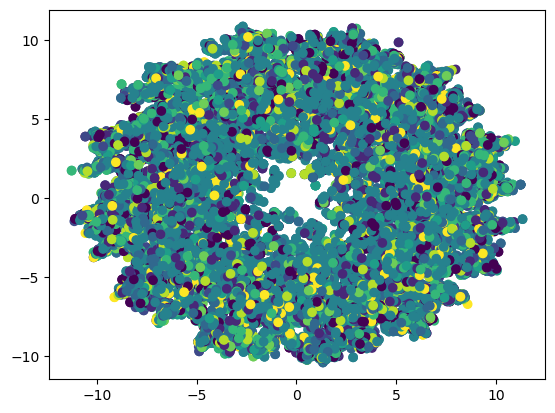

In [ ]:
# Take one layer of embeddings (you might want to adjust this based on your specific use case)
embeddings = [emb[0] for emb in bigbird_embeddings]

# Initialize PCA
pca = PCA(n_components=2)

# Fit and transform embeddings
embeddings_pca = pca.fit_transform(embeddings)

# Create a dictionary to map each category to a unique number
color_dict = {category: i for i, category in enumerate(df['drug_category'].unique())}

# Create a new column where the categories are replaced by their corresponding numbers
df['color'] = df['drug_category'].map(color_dict)

# Now you can color your scatter plot points based on this new column
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=df['color'])
plt.show()


In [ ]:
sentence = "This is a test sentence."
embedding = get_bigbird_embeddings(sentence, tokenizer, model)

print(embedding)

tensor([[ 1.2815, -0.1946, -1.2869,  ..., -0.0608, -1.0499,  0.2493],
        [-0.7351, -0.4872, -0.0857,  ...,  1.7758, -1.6801,  0.5483],
        [-0.8694,  0.7992,  0.0911,  ...,  2.2031, -1.5248,  0.6148],
        ...,
        [-0.6951,  0.4347,  0.5008,  ...,  1.7343, -0.5684,  0.3871],
        [-0.4545, -0.1278,  0.2725,  ...,  1.7790, -0.5420,  0.4444],
        [-0.4531,  0.0686, -0.0120,  ...,  0.5683, -0.7616, -0.0092]])


In [47]:
# Convert the list of embeddings to numpy array for sklearn compatibility
embeddings_array = np.array(df['report_embeddings'].tolist())

# Here we assume you have a target column in your dataframe to predict
target = df['drug_category'].values

# Average the embeddings across the token dimension
avg_embeddings = np.mean(embeddings_array, axis=1)

# First split to separate out the training set
X_train, X_test, y_train, y_test = train_test_split(avg_embeddings, target, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on your test set
y_pred = clf.predict(X_test)

In [48]:
from sklearn.metrics import classification_report
import pickle

# Predict on your training set
y_train_pred = clf.predict(X_train)
train_report = classification_report(y_train, y_train_pred, output_dict=True)

# Predict on your test set
y_test_pred = clf.predict(X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

# Print the classification reports
print('Train Classification Report:')
print(train_report)

print('Test Classification Report:')
print(test_report)

# Save the classification reports
with open('/content/drive/MyDrive/Colab Notebooks/Data/bbrf_train_report.pkl', 'wb') as f:
    pickle.dump(train_report, f)

with open('/content/drive/MyDrive/Colab Notebooks/Data/bbrf_test_report.pkl', 'wb') as f:
    pickle.dump(test_report, f)


Train Classification Report:
{'Cannabinoid': {'precision': 0.7856718192627824, 'recall': 0.6579536967886482, 'f1-score': 0.7161631215282481, 'support': 4017}, 'Depressant': {'precision': 0.7683018867924528, 'recall': 0.6593264248704663, 'f1-score': 0.709654932032067, 'support': 1544}, 'Dissociative': {'precision': 0.8794694348327566, 'recall': 0.8288043478260869, 'f1-score': 0.8533855623950756, 'support': 1840}, 'Entactogen/Empathogen': {'precision': 0.8660130718954249, 'recall': 0.8753578506936798, 'f1-score': 0.8706603876902859, 'support': 4541}, 'Entheogen': {'precision': 0.9022524436889078, 'recall': 0.8532958199356914, 'f1-score': 0.8770915100185913, 'support': 2488}, 'Opioid': {'precision': 0.8890243902439025, 'recall': 0.8586572438162544, 'f1-score': 0.8735769922109048, 'support': 1698}, 'Other': {'precision': 0.8825872978673541, 'recall': 0.8697459584295612, 'f1-score': 0.8761195765964871, 'support': 4330}, 'Pharmaceutical': {'precision': 0.8672134781644868, 'recall': 0.8597802

In [49]:
# Convert the list of embeddings to numpy array for sklearn compatibility
embeddings_array = np.array(df['report_embeddings'].tolist())

# Max pooling the embeddings across the token dimension
max_pool_embeddings = np.max(embeddings_array, axis=1)

# Then use these max pooled embeddings for your split
X_train, X_test, y_train, y_test = train_test_split(max_pool_embeddings, target, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
mpclf = RandomForestClassifier(n_estimators=100, random_state=42)
mpclf.fit(X_train, y_train)

# Predict on your test set
y_pred = mpclf.predict(X_test)

In [51]:
# Predict on your training set
y_train_pred = mpclf.predict(X_train)
train_report = classification_report(y_train, y_train_pred, output_dict=True)

# Predict on your test set
y_test_pred = mpclf.predict(X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

# Print the classification reports
print('Train Classification Report:')
print(train_report)

print('Test Classification Report:')
print(test_report)

with open('/content/drive/MyDrive/Colab Notebooks/Data/bbrfmp_train_report.pkl', 'wb') as f:
    pickle.dump(train_report, f)

with open('/content/drive/MyDrive/Colab Notebooks/Data/bbrfmp_test_report.pkl', 'wb') as f:
    pickle.dump(test_report, f)

Train Classification Report:
{'Cannabinoid': {'precision': 0.7493486190724336, 'recall': 0.6258977149075081, 'f1-score': 0.6820822957429147, 'support': 4595}, 'Depressant': {'precision': 0.7462987886944819, 'recall': 0.6261998870694523, 'f1-score': 0.6809947804728278, 'support': 1771}, 'Dissociative': {'precision': 0.880020597322348, 'recall': 0.8088026502602934, 'f1-score': 0.8429099876695438, 'support': 2113}, 'Entactogen/Empathogen': {'precision': 0.8522727272727273, 'recall': 0.8719240457275722, 'f1-score': 0.861986399770137, 'support': 5161}, 'Entheogen': {'precision': 0.8883911907428145, 'recall': 0.8406923348640056, 'f1-score': 0.8638838475499092, 'support': 2831}, 'Opioid': {'precision': 0.8925619834710744, 'recall': 0.8406850025947068, 'f1-score': 0.8658471405665419, 'support': 1927}, 'Other': {'precision': 0.8728061119141028, 'recall': 0.8563614262560778, 'f1-score': 0.8645055731669904, 'support': 4936}, 'Pharmaceutical': {'precision': 0.8543033577769201, 'recall': 0.85069177

In [ ]:
# Get unique drug_category values
drug_categories = sorted(y_test.unique())

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=drug_categories, yticklabels=drug_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [59]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, make_scorer

# Assuming clf is your trained classifier
# Assuming X_test and y_test are your test data and labels, respectively

# Define a custom precision scorer for multiclass classification
precision_scorer = make_scorer(precision_score, average=None, zero_division=1)

# Convert X_test (a NumPy array) to a DataFrame with appropriate column names
# Replace 'feature_0', 'feature_1', ..., 'feature_n' with your actual feature names
feature_names = ['feature_0', 'feature_1', ..., 'feature_n']
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Perform permutation importance with precision as the scoring metric
results = permutation_importance(clf, X_test_df, y_test, scoring=precision_scorer)

# Get importance
importance = results.importances_mean

# Create a dictionary to store feature importance scores with their corresponding words
importance_dict = {feature_names[i]: importance[i] for i in range(len(feature_names))}

# Sort the dictionary by importance score in descending order
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display the top 25 most important words
top_25 = sorted_importance[:25]
for i, (word, score) in enumerate(top_25, 1):
    print(f"{i}. Word: {word}, Score: {score:.5f}")

AttributeError: ignored